In [77]:
import numpy as np
from queue import Queue
from mip import *
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import time

Teraz udało się pobrać wszystkie potrzebne narzędzia. Sprawdźmy jeszcze licencję GUROBI:

In [78]:
try:
    # Inicjalizacja modelu
    model = gp.Model()

    # Wyświetlenie informacji o licencji
    print("Numer licencji:", model.getParamInfo("Username"))
    print("Typ licencji:", model.getParamInfo("LicenseID"))
    print("Data ważności licencji(YYYYMMDD):", model.LicenseExpiration)

except gp.GurobiError as e:
    print("Błąd Gurobi:", e)

Numer licencji: ('Username', <class 'str'>, 'kamil', '', '', '')
Typ licencji: ('LicenseID', <class 'int'>, 0, 0, 2000000000, 0)
Data ważności licencji(YYYYMMDD): 20250419


Definicja infinity (używana w algorytmie HK):

In [79]:
infinity = np.iinfo(np.int32(10)).max
print(infinity)

2147483647


Definicja algorytmów rozwiązujących matching grafów dwudzielnych:
Funkcje są postaci: def nazwa_(U, V, E, debug=False), np. def HK_(U, V, E) gdzie:
1) U to liczba wierzchołków w częsci lewej 'U', zakładamy, że numery wierzchołków to 0, 1, ...., U - 1,
2) V to liczba wierzchołków w 'V', zakładamy, że numery wierzchołków to 0, 1, ..., V - 1,
3) E to krawędzie między U oraz V, są w postaci listy sąsiedztwa, ma ona dokładnie U elemtów, każdy element to
   np.array([int]), gdzie liczby w elemencie to numery wierzchołków w 'V' do których istnieje krawędź z odpowiedniego wierzchołka z 'U',
4) debug = True oznacza wersję testową, będą wyświetlały się informacje diagnostyczne, debug = False oznacza, że nie będą wyświetlały się informacje diagnostyczne(oprócz tych z modeli CBC, GUROBI).

Po nazwie jest znak '_', który oznacza, że API funkcji jest jak wyżej. Zrobiłem tak, ponieważ w opisie zadania jest wymóg, aby czytać graf z pliku. Te funkcje są postaci: def nazwa(), np. def HK().

a)

Funkcja HK(oraz pomocnicze do niej używane):

In [80]:
def BFS(U, V, E, Pair_U, Pair_V, Dist):
    Q = Queue(maxsize = 2 * U)
    for u in range(U):
        if Pair_U[u] == -1:
            Dist[u] = 0
            Q.put(u)
        else:
            Dist[u] = infinity
    Dist[-1] = infinity
    while not Q.empty():
        u = Q.get()
        if Dist[u] < Dist[-1]:
            for v in E[u]:
                if Dist[Pair_V[v]] == infinity:
                    Dist[Pair_V[v]] = Dist[u] + 1
                    Q.put(Pair_V[v])
    return Dist[-1] != infinity

def DFS(u, E, Pair_U, Pair_V, Dist):
    if u != -1:
        for v in E[u]:
            if Dist[Pair_V[v]] == Dist[u] + 1:
                if DFS(Pair_V[v], E, Pair_U, Pair_V, Dist):
                    Pair_V[v] = u
                    Pair_U[u] = v
                    return True
        Dist[u] = infinity
        return False
    return True

def HK_(U, V, E, debug=False):
    if debug:
        print("HK...")
    # U is number of vecrtices in 'U', V - number of vertices in V.
    # I assume that vertices from 'U' are numbered: 0, 1, 2,..., U - 1,
    # vertices from 'V' have indices: 0, 1, ..., V - 1.
    Pair_U = - np.ones(U, dtype = int)
    Pair_V = - np.ones(V, dtype = int)
    Dist = np.ones(U + 1, dtype = int) 
    # Dist[-1] = Dist[U] - because python works this way. NIL = -1.
    # print(Dist)
    matching = 0
    debug_phases = 1
    while BFS(U, V, E, Pair_U, Pair_V, Dist):
        debug_phases += 1
        for u in range(U):
            if Pair_U[u] == -1:
                if DFS(u, E, Pair_U, Pair_V, Dist):
                    matching = matching + 1
    if debug:
        print("Matching edges:")
        print(Pair_U) 
        # We can check with which vertices from 'V' are vertices from 'U' connected. -1 means it is not connected.
        print(Pair_V)
        # Should be Pair_V[Pair_U[v]] = v.
        print("Phases:", debug_phases)
        # Number of phases, usefull during debugging.
    return matching


Prosty test poprawności - używając prostej funkcji brute-force nazwanej brute(U, V, E, debug=False), o tym samym schemacie co algorytm HK_, która testuje wszystkie możliwe 
podzbiory krawędzi, sprawdza czy dany podzbiór to matching, a następnie zwraca maksymalny matching. 
Funkcja zwraca wynik w postaci liczby krawędzi, ale debug pozwala dowiedzieć się, jak dokładnie wygląda maksymalny matching.
Ze względu na dużą złożoność warto testować tylko dla małych grafów.

In [81]:
# Checks if subset of edges is matching. 
# Argument e is subset of edges is list of pairs(tuples).
# Pair (u, v) means edge from u in 'U' to v in 'V'.
# It is assumed that pairs are different and proper. 
def check(e):
    u = set()
    v = set()
    for (a, b) in e:
        u.add(a)
        v.add(b)
    return len(u) == len(e) and len(v) == len(e)

# Simple backtracking. Constructs subsets, checks them and return best.
# E means edges as pairs(tuple) from 'U' to 'V', which are not yet decided to include or not to subset.
# t means edges as pairs(tuple) from 'U' to 'V', which are already decided to include in subset.
def backtracking(E, t):
    if E == []:
        if not check(t):
            return []
        else:
            # print("Found t: ", t)
            return t
    l = backtracking(E[:-1], t.copy())
    # print("Just got l: ", l)
    t.append(E[-1])
    r = backtracking(E[:-1], t.copy())
    # print("Just got r: ", r)
    t.pop(-1)
    if len(l) > len(r):
        return l
    return r

# Changes E - adjacent lists of edges, in graph G(U, V, E), to edges as list of pairs.
def edgesToPairs(U, V, E):
    E_p = []
    for u in range(U):
        for v in E[u]:
            E_p.append((u, v))
    return E_p

def brute(U, V, E, debug=False):
    if debug:
        print("Brute...")
    E_p = edgesToPairs(U, V, E)
    matching_edges = backtracking(E_p, [])
    if debug:
        print("Matching edges:", matching_edges)
    return len(matching_edges)

Teraz czas na generatorkę grafu losowego, U wierzchołków w 'U', V w 'V', prawdopodobieństwo krawędzi to p(będzie używana w podpunkcie c)

In [82]:
def generateEdgesWithProbability(U, V, p, debug=False):
    if debug:
        print("Starting generating...")
    edgesMatrix = (np.random.rand(U, V) < p).astype(int)
    # Returns table of boolean values with True probability p.
    # print(edgesMatrix)
    row = np.arange(V, dtype=int) + 1
    # So: np.array([1, 2, ..., V])
    # print(row)
    vector = np.tile(row, (U, 1))
    # print(vector)
    edges = edgesMatrix * vector
    # Matrix of edges, 0 means no edges, v > 0 means edge to v - 1 vertex.
    # print(times)
    return [t[t > 0] - 1 for t in edges]

Sprawdźmy, czy działa poprawnie:

In [83]:
U = 6
V = 6
p = 0.3

E = generateEdgesWithProbability(U, V, p, True)
print("Edges in test:", E)
print("HK solution:", HK_(V, U, E, True))
print("Brute solution:", brute(U, V, E, True))
# Dla U = V = 10 nawet przetestowałem i też działa, tylko brute jest za wolny.

Starting generating...
Edges in test: [array([2]), array([2, 3, 4, 5]), array([5]), array([3]), array([], dtype=int64), array([5])]
HK...
Matching edges:
[ 2  4  5  3 -1 -1]
[-1 -1  0  3  1  2]
Phases: 3
HK solution: 4
Brute...
Matching edges: [(5, 5), (3, 3), (1, 4), (0, 2)]
Brute solution: 4


b)

PLcbc_

In [84]:
# Solves and shows result using ready model in m. e is reference for edges(variables in model).
# Assumes mip model.
def PLsolver(m, debug):
    if debug:
        print("PLsolver...")
    E_p = edgesToPairs(U, V, E)
    if len(E_p) == 0:
        return 0
    S = range(len(E_p))
    if not debug:
        m.verbose = 0
    e = [m.add_var(var_type=BINARY) for i in S]

    # Adding constraints for the vertices in 'U'.
    for u in range(U):
        m += xsum(e[i] for i in S if E_p[i][0] == u) <= 1

    # Adding constraints for the vertices in 'V'.
    for v in range(V):
        m += xsum(e[i] for i in S if E_p[i][1] == v) <= 1

    # Setting objective.
    m.objective = maximize(xsum(e[i] for i in S))
    
    result = -1
    # -1 means error.
    status = m.optimize()
    if status == OptimizationStatus.OPTIMAL:
        result = int(m.objective_value)
        if debug:
            print('Found optimal solution with cost {}'.format(m.objective_value))
    elif debug and status == OptimizationStatus.FEASIBLE:
        print('Found feasible solution {}, with cost: {}'.format(m.objective_value, m.objective_bound))
    elif debug and status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('No solution found, lower bound is: {}'.format(m.objective_bound))
    if debug and (status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE):
        print('Solution:')
        # for v in m.vars:
        #     if abs(v.x) > 1e-6:  # Only positive variables.
        #         print('{} : {}'.format(v.name, v.x))
        selected = [i for i in range(len(e)) if e[i].x >= 0.99]
        print("Edges indices: {} ".format(selected))
    return result

def PLcbc_(U, V, E, debug=False):
    if debug:
        print("PLcbc...")
    m = Model(solver_name=CBC)
    return PLsolver(m, debug)

Prosty test CBC:

In [85]:
print("PLcbc result:", PLcbc_(U, V, E, True))

PLcbc...
PLsolver...
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 0 (-9) rows, 0 (-8) columns and 0 (-16) elements
Clp0000I Optimal - objective value 4
Coin0511I After Postsolve, objective 4, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 4 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Found optimal solution with cost 4.0
Solution:
Edges indices: [0, 3, 5, 6] 
PLcbc result: 4


PLgur_

In [86]:
def PLgur_(U, V, E, debug=False):
    if debug:
        print("PLgur")
    m = Model(solver_name='GRB')
    return PLsolver(m, debug)
    # ...
    # m = gp.Model()
    # if not debug:
    #     m.Params.LogToConsole = 0
    #     m.Params.LogFile = ""
    # e = [m.addVar(vtype=GRB.BINARY) for i in S]
    # for u in range(U):
    #     m.addConstr(gp.quicksum(e[i] for i in S if E_p[i][0] == u) <= 1)
    # for v in range(V):
    #     m.addConstr(gp.quicksum(e[i] for i in S if E_p[i][1] == v) <= 1)
    # m.setObjective(gp.quicksum(e[i] for i in S), GRB.MAXIMIZE)
    # m.optimize()
    # result = -1
    # # -1 means error.
    # if debug:
    #     print(model.status)
    # if model.status == 1:
    #     result = int(m.getObjective().getValue())
    # if debug:
    #     print("Edges if matching:")
    #     for v in m.getVars():
    #         print(f"{v.VarName} = {v.X}")
    # return result
    # print(e[0].Xn)
    # selected = [i for i in range(3) if e[i].X >= 0.99]
    # print(selected)

Prosty test GUROBI:

In [87]:
print("PLgur result:", PLgur_(U, V, E, True))

PLgur
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc3007W No integer variables
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLsolver...
Set parameter NodeLimit to value 1073741824
Set parameter SolutionLimit to value 1073741824
Set parameter IntFeasTol to value 1e-06
Set parameter Method to value 3
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: 12th Gen Intel(R) Core(TM) i5-1235U, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 12 rows, 8 columns and 16 nonzeros
Model fingerprint: 0xe161e1e7
Variable types: 0 continuous, 8 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

c)

Będę korzystać z generateEdgesWithProbability w celu stworzenia odpowiednich grafów.

Testing HK, PLcbc, PLgur
Testing probability: 0.0
HK: 0 PLcbc: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
Testing probability: 0.01
HK: 278 PLcbc: 278 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 278
Testing probability: 0.05
HK: 300 PLcbc: 300 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 300
Testing probability: 0.1
HK: 300 PLcbc: 300 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 300
Testing probability: 0.3
HK: 300 PLcbc: 300 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 300
Testing probability: 0.5
HK: 300 PLcbc: 300 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 300
Testing probability: 0.7
HK: 300 PLcbc: 300 Set parameter Username
Academic license - for non-commercia

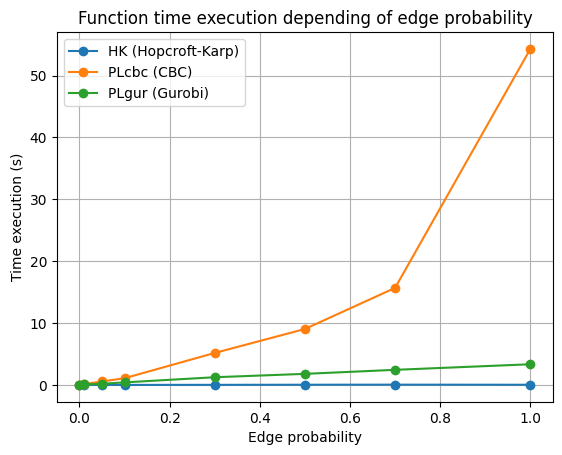

Testing HK, PLgur
Testing probability: 0.0
HK: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
HK: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
HK: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
HK: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
HK: 0 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 0
Testing probability: 0.001
HK: 51 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 51
HK: 60 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 60
HK: 89 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 89
HK: 59 Set parameter Username
Academic license - for non-commercial use only

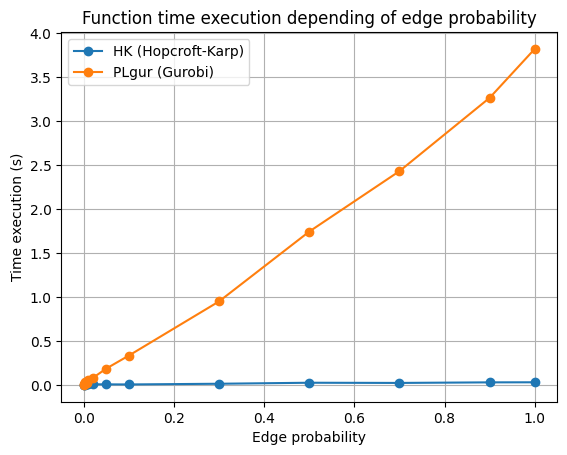

In [88]:
# Probabilities of edge occurence in graph - for testing
probability = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]

U = V = 300

num_trials = 1

# Time measurement for all functions and edge probability
times_HK = []
times_PLcbc = []
times_PLgur = []

print("Testing HK, PLcbc, PLgur")

for p in probability:
    print(f"Testing probability: {p}", )
    times_HK_p = []
    times_PLcbc_p = []
    times_PLgur_p = []

    for _ in range(num_trials):
        E = generateEdgesWithProbability(U, V, p)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_p.append(end_time - start_time)

        start_time = time.time()
        print("PLcbc:", PLcbc_(U, V, E), end=' ')
        end_time = time.time()
        times_PLcbc_p.append(end_time - start_time)

        start_time = time.time()
        print("PLgur:", PLgur_(U, V, E))
        end_time = time.time()
        times_PLgur_p.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_p))
    times_PLcbc.append(np.mean(times_PLcbc_p))
    times_PLgur.append(np.mean(times_PLgur_p))

# Diagram
plt.plot(probability, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(probability, times_PLcbc, marker='o', label='PLcbc (CBC)')
plt.plot(probability, times_PLgur, marker='o', label='PLgur (Gurobi)')
plt.title('Function time execution depending of edge probability')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_PLcbc_PLgur.png')
plt.show()

print("Testing HK, PLgur")

probability = [0.0, 0.001, 0.003, 0.006, 0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
times_HK = []
times_PLgur = []
num_trials = 5

for p in probability:
    print(f"Testing probability: {p}")
    times_HK_p = []
    times_PLgur_p = []

    for _ in range(num_trials):
        E = generateEdgesWithProbability(U, V, p)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_p.append(end_time - start_time)

        start_time = time.time()
        print("PLgur:", PLgur_(U, V, E))
        end_time = time.time()
        times_PLgur_p.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_p))
    times_PLgur.append(np.mean(times_PLgur_p))

# Diagram
plt.plot(probability, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(probability, times_PLgur, marker='o', label='PLgur (Gurobi)')
plt.title('Function time execution depending of edge probability')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_PLgur.png')
plt.show()

d)

Opis konstrukcji grafu: różne spójne składowe wcale nie są zupełnie niezależne w algorytmie HK. Wystarczy aby graf miał spójne składowe w postaci rozłącznych wierzchołkowo ścieżek, niech te ścieżki mają 1, 3, 5, 7, ..., (2 * d + 1) krawędzi, niech kolejność krawędzi w listach sąsiedztwa najpierw zablokuje w 1 fazie HK wewnętrzne krawędzie, czyli każdą ścieżkę oprócz 1 można powiększyć ścieżką powiększającą alternującą o 1. Przykład: takim grafem jest graf dla którego n = U = V = 10 oraz E = [array([0]), array([2, 1]), array([2]), array([4, 3]), array([5, 4]), array([5]), array([7, 6]), array([8, 7]), array([9, 8]), array([9])]. Tutaj wierzchołki na krótszej ścieżce mają mniejsze numery, pierwszy wierzchołek na ścieżce należy do 'V', potem do 'U', itd., ostatni należy do 'U'. Każdy należący do 'U' na ścieżce, oprócz ostatniego, najpierw łączy się z wierzchołkiem nalężącym do 'V' o większym numerze, a potem mniejszym. Ostatni z 'U' łączy się z tylko 1 wierzchołkiem. Więcej informacji o konstrukcji będzie widać w samym algorytmie. Szczegół dla ustalonego n: suma wierzchołków z 'U' z takich ścieżek nie musi wynosić dokładnie n, ale będzie tego rzędu. Budujemy największy taki graf jaki jest możliwy, a pozostałe wierzchołki ustawiamy jako rozłączne ze wszystkim.

Czemu to działa? Po pierwsze ścieżka o (2 * k + 1) krawędziach ma k wierzchołków z 'U' i tyle samo z 'V'. Szukamy więc d największego, które spełnia 1 + 2 + ... + d <= n. Ale 1 + 2 + ... + d = \theta(d^2), więc 1 + 2 + ... + d = /theta(n) (różnica = O(\sqrt(n))). Ograniczmy się więc do przypadku, gdy 1 + 2 + ... + d = n. 
Zauważmy: |E| = O(V)
Po przejściu 1 fazy każdą ścieżkę (oprócz 1-szej) można rozszerzyć o 1, tylko na 1 sposób - ścieżka powiększająca zaczyna się na ostatnim wierzchołku z 'U'. Ale BFS sprawi, że w danej fazie tylko 1 ścieżkę można rozszerzyć - w 2 fazie o długości 3, w 3 fazie - o długości 5 itd., bo w każdej fazie pozostałe ścieżki niepowiększone są dłuższe od tej ścieżki. Zatem faz będzie d, czyli sqrt(V). To nie oznacza jeszcze, że długość fazy zajmie O(|E|). Ale tak będzie, bo tak się składa, że ograniczając się do faz od (d/2) do (3/4 d) faz długość ścieżki powiększającej dla fazy będzie >= (2 * d + 1) / 2 >= d, ścieżek po których przejdzie jest co najmniej (d/4) (ostatnie ścieżki), więc długość tych faz >= /omega(d^2), tych faz jest /theta(d), co daje złożoność /theta(d^(3/2) = /theta(|E|*sqrt(V))) - tak miało być. Algorytm:

In [89]:
# Assumes that n >= 1.
def countSizeForPessimisticForHK(n):
    N = 1
    s = 0
    while s + N <= n:
        s += N
        N += 1
    return s

# Returns U, V, E - arguments to HK etc.
def pessimisticForHK(n):
    N = countSizeForPessimisticForHK(n)
    if n != N:
        (_, _, E) = pessimisticForHK(N)
        for i in range(n - N):
            E.append(np.array([], dtype=int))
        return (n, n, E)
    # if n == N:
    print(N)
    N = 1
    s = 0
    E = []
    while s + N <= n:
        # First vertex in U from recent path has index s. Same for V.
        # This path has N vertices from U and N vertices from V.
        # Next identificators of this path have consecutive identifiers.
        # Order of adjacent vertices of U is important:
        # * last vertex u in U has only 1 neighbour: u in V
        # * for every vertex u in U except last one first adjacent is u + 1 in V,
        # second is u in V.
        nr = 0
        while nr < N - 1:
            u = s + nr
            E.append(np.array([u + 1, u]))
            nr += 1
        E.append(np.array([s + nr]))
        s += N
        N += 1
    return (n, n, E)

Prosty przykład dla n = 11:

In [90]:
print(pessimisticForHK(11))
U, V, E = pessimisticForHK(11)
print(HK_(U, V, E, True))
print(PLcbc_(U, V, E, True))
print(PLgur_(U, V, E, True))

10
(11, 11, [array([0]), array([2, 1]), array([2]), array([4, 3]), array([5, 4]), array([5]), array([7, 6]), array([8, 7]), array([9, 8]), array([9]), array([], dtype=int64)])
10
HK...
Matching edges:
[ 0  1  2  3  4  5  6  7  8  9 -1]
[ 0  1  2  3  4  5  6  7  8  9 -1]
Phases: 5
10
PLcbc...
PLsolver...
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 0 (-20) rows, 0 (-16) columns and 0 (-32) elements
Clp0000I Optimal - objective value 10
Coin0511I After Postsolve, objective 10, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 10 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Found optimal solution with cost 10.0
Solution:
Edges indices: [0, 2, 3, 5, 7, 8, 10, 12, 14, 15] 
10
PLgur
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc3007W No integer variables
Total tim

f)

Algorytm AlternativeToHK_ to implementacja typowego algorytmu turbo-matching, czyli "polskiego" tricku na olimpiadę informatyczną na znajdowanie ścieżek powiększających alternujących tak, aby w iteracji próby powiększenia nie odwiedzać wierzchołka więcej niż raz. To heurystyczny algorytm, został spisany przez Jakuba Bachurskiego w "https://kubin.w.staszic.waw.pl/static/pages/esoterica/matching/matching.pdf".

In [91]:
def augment(u, E, Pair_V, Pair_U, visited):
    visited[u] = True
    for v in E[u]:
        if Pair_V[v] == -1:
            Pair_V[v] = u; 
            Pair_U[u] = v
            return True
    for v in E[u]:
        if not visited[Pair_V[v]] and augment(Pair_V[v], E, Pair_V, Pair_U, visited):
            Pair_V[v] = u 
            Pair_U[u] = v 
            return True
    return False

def AlternativeToHK_(U, V, E, debug=False):
    if debug:
        print("AlternativeToHK(turbo-matching)...")
    Pair_U = - np.ones(U, dtype = int)
    Pair_V = - np.ones(V, dtype = int)
    matching = 0
    debug_phases = 1
    while True:
        debug_phases += 1
        visited = np.zeros(U, dtype=bool)
        any = False
        for u in range(U):
            if Pair_U[u] == -1 and augment(u, E, Pair_V, Pair_U, visited):
                matching += 1
                any = True
        if not any:
            break
    if debug:
        print("Matching edges:")
        print(Pair_U) 
        # We can check with which vertices from 'V' are vertices from 'U' connected. -1 means it is not connected.
        print(Pair_V)
        # Should be Pair_V[Pair_U[v]] = v.
        print("Phases:", debug_phases)
        # Number of phases, usefull during debugging.
    return matching

Proste testy:

Small test for pessimistic
10
(11, 11, [array([0]), array([2, 1]), array([2]), array([4, 3]), array([5, 4]), array([5]), array([7, 6]), array([8, 7]), array([9, 8]), array([9]), array([], dtype=int64)])
10
HK...
Matching edges:
[ 0  1  2  3  4  5  6  7  8  9 -1]
[ 0  1  2  3  4  5  6  7  8  9 -1]
Phases: 5
10
PLcbc...
PLsolver...
Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 0 (-20) rows, 0 (-16) columns and 0 (-32) elements
Clp0000I Optimal - objective value 10
Coin0511I After Postsolve, objective 10, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 10 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Found optimal solution with cost 10.0
Solution:
Edges indices: [0, 2, 3, 5, 7, 8, 10, 12, 14, 15] 
10
PLgur
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc3007W No 

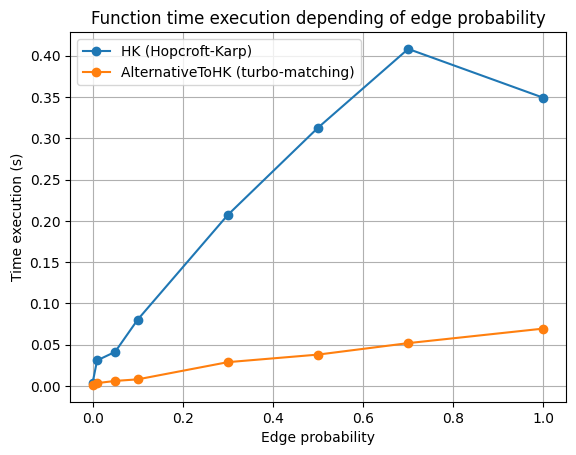


Big test for pessimistic (HK and Aternative)
Testing n: 1
1
HK: 1 AlternativeToHK: 1
Testing n: 10
10
HK: 10 AlternativeToHK: 10
Testing n: 100
91
HK: 91 AlternativeToHK: 91
Testing n: 500
496
HK: 496 AlternativeToHK: 496
Testing n: 1000
990
HK: 990 AlternativeToHK: 990
Testing n: 2000
1953
HK: 1953 AlternativeToHK: 1953
Testing n: 5000
4950
HK: 4950 AlternativeToHK: 4950
Testing n: 10000
9870
HK: 9870 AlternativeToHK: 9870
Testing n: 50000
49770
HK: 49770 AlternativeToHK: 49770
Testing n: 100000
99681
HK: 99681 AlternativeToHK: 99681
Testing n: 200000
199396
HK: 199396 AlternativeToHK: 199396
Testing n: 350000
349866
HK: 349866 AlternativeToHK: 349866
Testing n: 500000
499500
HK: 499500 AlternativeToHK: 499500


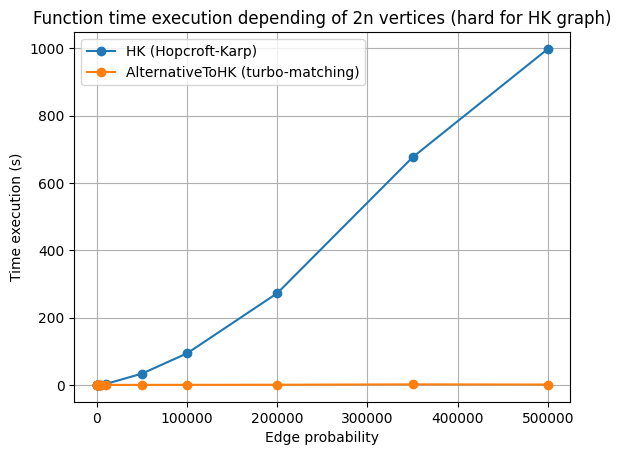

In [92]:
print("Small test for pessimistic")
print(pessimisticForHK(11))
U, V, E = pessimisticForHK(11)
print(HK_(U, V, E, True))
print(PLcbc_(U, V, E, True))
print(PLgur_(U, V, E, True))
print(AlternativeToHK_(U, V, E, True), "\n")

print("Simple test for small random graphs")

probability = [0.0, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]

U = V = 1000

num_trials = 5

# Time measurement for all functions and edge probability
times_HK = []
times_Alternative = []

print("Testing HK, PLcbc, PLgur")

for p in probability:
    print(f"Testing probability: {p}", )
    times_HK_p = []
    times_Alternative_p = []

    for _ in range(num_trials):
        E = generateEdgesWithProbability(U, V, p)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_p.append(end_time - start_time)

        start_time = time.time()
        print("AlternativeToHK:", AlternativeToHK_(U, V, E))
        end_time = time.time()
        times_Alternative_p.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_p))
    times_Alternative.append(np.mean(times_Alternative_p))

# Diagram
plt.plot(probability, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(probability, times_Alternative, marker='o', label='AlternativeToHK (turbo-matching)')
plt.title('Function time execution depending of edge probability')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_Alternative_random.png')
plt.show()

print()
print("Big test for pessimistic (HK and Aternative)")
n_size = [1, 10, 100, 500, 1000, 2000, 5000, 10000, 50000, 100000, 200000, 350000, 500000]

num_trials = 1

# Time measurement for all functions and edge probability
times_HK = []
times_Alternative = []

for n in n_size:
    print(f"Testing n: {n}", )
    times_HK_n = []
    times_Alternative_n = []

    for _ in range(num_trials):
        U, V, E = pessimisticForHK(n)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_n.append(end_time - start_time)

        start_time = time.time()
        print("AlternativeToHK:", AlternativeToHK_(U, V, E))
        end_time = time.time()
        times_Alternative_n.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_n))
    times_Alternative.append(np.mean(times_Alternative_n))

# Diagram
plt.plot(n_size, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(n_size, times_Alternative, marker='o', label='AlternativeToHK (turbo-matching)')
plt.title('Function time execution depending of 2n vertices (hard for HK graph)')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_Alternative_pessimistic_hard.png')
plt.show()

e)

Testing HK, PLcbc, PLgur
Testing HK, PLcbc, PLgur
Testing n: 1
1
HK: 1 PLcbc: 1 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 1
Testing n: 10
10
HK: 10 PLcbc: 10 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 10
Testing n: 100
91
HK: 91 PLcbc: 91 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 91
Testing n: 500
496
HK: 496 PLcbc: 496 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 496
Testing n: 1000
990
HK: 990 PLcbc: 990 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 990
Testing n: 2000
1953
HK: 1953 PLcbc: 1953 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 1953
Testing n: 5000
4950
HK: 4950 PLcbc: 4950 Set parameter Username
Academic license - for non-commercial use only - expires 2

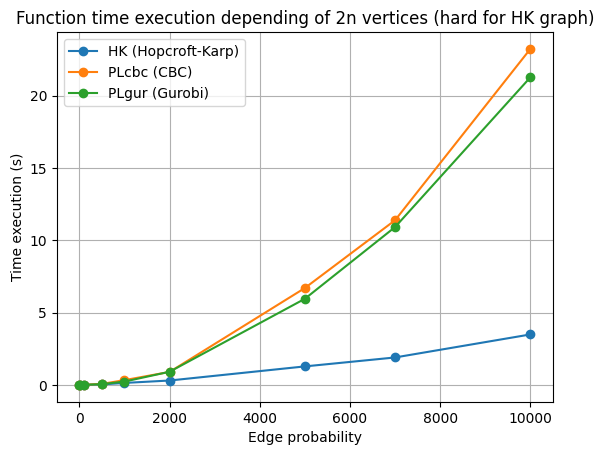

CBC is too slow so I will continue with HK and GUROBI
Testing HK, PLgur
Testing HK, PLcbc, PLgur
Testing n: 1
1
HK: 1 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 1
Testing n: 10
10
HK: 10 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 10
Testing n: 100
91
HK: 91 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 91
Testing n: 500
496
HK: 496 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 496
Testing n: 1000
990
HK: 990 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 990
Testing n: 10000
9870
HK: 9870 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 9870
Testing n: 20000
19900
HK: 19900 Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
PLgur: 19900
T

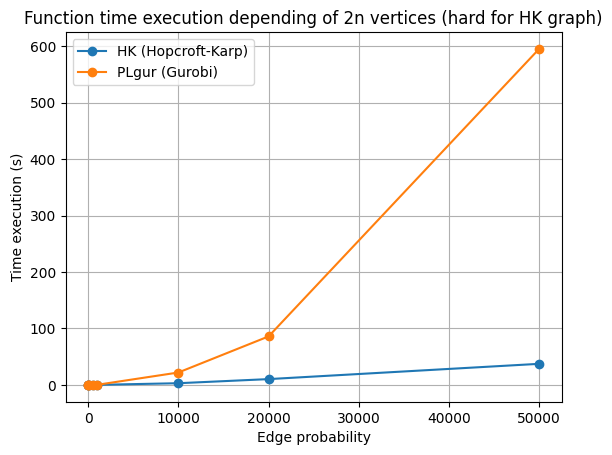

In [95]:
# Choosing n for testing
print("Testing HK, PLcbc, PLgur")
n_size = [1, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]

num_trials = 1

# Time measurement for all functions and edge probability
times_HK = []
times_PLcbc = []
times_PLgur = []

print("Testing HK, PLcbc, PLgur")

for n in n_size:
    print(f"Testing n: {n}", )
    times_HK_n = []
    times_PLcbc_n = []
    times_PLgur_n = []

    for _ in range(num_trials):
        U, V, E = pessimisticForHK(n)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_n.append(end_time - start_time)

        start_time = time.time()
        print("PLcbc:", PLcbc_(U, V, E), end=' ')
        end_time = time.time()
        times_PLcbc_n.append(end_time - start_time)

        start_time = time.time()
        print("PLgur:", PLgur_(U, V, E))
        end_time = time.time()
        times_PLgur_n.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_n))
    times_PLcbc.append(np.mean(times_PLcbc_n))
    times_PLgur.append(np.mean(times_PLgur_n))

# Diagram
plt.plot(n_size, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(n_size, times_PLcbc, marker='o', label='PLcbc (CBC)')
plt.plot(n_size, times_PLgur, marker='o', label='PLgur (Gurobi)')
plt.title('Function time execution depending of 2n vertices (hard for HK graph)')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_PLcbc_PLgur_hard.png')
plt.show()

# We can see that much CBC is too slow. So I will just continue with HK and GUROBI from this point.
print("CBC is too slow so I will continue with HK and GUROBI")
print("Testing HK, PLgur")

n_size = [1, 10, 100, 500, 1000, 10000, 20000, 50000]

num_trials = 1

# Time measurement for all functions and edge probability
times_HK = []
times_PLgur = []

print("Testing HK, PLcbc, PLgur")

for n in n_size:
    print(f"Testing n: {n}", )
    times_HK_n = []
    times_PLgur_n = []

    for _ in range(num_trials):
        U, V, E = pessimisticForHK(n)

        start_time = time.time()
        print("HK:", HK_(U, V, E), end=' ')
        end_time = time.time()
        times_HK_n.append(end_time - start_time)

        start_time = time.time()
        print("PLgur:", PLgur_(U, V, E))
        end_time = time.time()
        times_PLgur_n.append(end_time - start_time)

    times_HK.append(np.mean(times_HK_n))
    times_PLgur.append(np.mean(times_PLgur_n))

# Diagram
plt.plot(n_size, times_HK, marker='o', label='HK (Hopcroft-Karp)')
plt.plot(n_size, times_PLgur, marker='o', label='PLgur (Gurobi)')
plt.title('Function time execution depending of 2n vertices (hard for HK graph)')
plt.xlabel('Edge probability')
plt.ylabel('Time execution (s)')
plt.legend()
plt.grid(True)
plt.savefig('wykres_HK_PLgur_hard.png')
plt.show()

g)

Nie mam pomysłu na kolejny graf który byłby ciekawy. Zatem pozostanę przy grafie pesymistycznym dla HK oraz randomowym. 
Wnioski:
1) Wykres dla "Big test for pessimistic (HK and Aternative)": 
Alternative (turbo-matching) to pozioma kreska na wykresie, podczas gdy czas HK rośnie aż do 1000s. Wiemy, że złożoność HK na tym przykładzie to theta(E*sqrt(V)) = theta(V*sqrt(V)). V rzędu 500 000, czyli ilość obliczeń jest rzędu 500 000 000. Stąd aż tyle czasu. Na 1 sekundę przypada około 500 000 obliczeń na moim komputerze. Czas AlternativeToHK wynosi co najmniej omega(V), z wykresu wydaje się, że może maks 10 sekund trwają obliczenia, czyli obstawiam że efektywny czas to O(ElogV). Ale uwaga: prosta analiza pokazuje, że w tym przykładzie przejdzie po prostu sqrt(V) razy po kolejnych ścieżkach, tylko 1 iteracja będzie, więc ten przykład niewiele mówi: złożoność to theta(E).
2) Wykres dla "Simple test for small random graphs":
   To szczególny graf i bardzo łatwo znaleźć krawędź gdy jest super gęsty(w szczególności dla p = 1 będzie tylko 1 iteracja, od razu zmatchuje HK każdą krawędź, stąd spadek w czasie działania niż dla p = 0.7). Zatem porównajmy czas dla p = 0.7. Dla HK to 0.4s, dla AlternativeToHK: 0.05s. W praktyce 8 razy lepszy. W typowym przypadku wydaje się więc, że złoność jest bliska liniowej dla turbo-matching. W praktyce O(ElogV) wydaje się być dobrym ograniczeniem. Oczywiście teoretycznie możliwe, że istnieje kontrprzykład i złożoność wyniesie theta(EV) (bo to heurystyczny algorytm), ale bardzo ciężko wymyślić. Tak więc turbo-matching działa.
3) Porównajmy czas działania CBC, GUROBI i HK.
   Jak widać zawsze solvery PL są wolniejsze. Zawsze czas HK < czas PLgur < czas PLcbc. Wykresy porównujące te 3 algorytmy na raz pokazują, że w instancji trudnej dla HK - GUROBI działa podobnie do CBC, ale dla losowego grafu GUROBI jest wyraźnie szybszy(55s CBC - 4s GUROBI). Te wykresy nie pozwalają porównać jak bardzo szybki jest HK - to zbyt duża różnica.
4) Porównajmy czas działania GUROBI i HK.
   Na losowym grafie to HK jest dużo szybsze na losowym grafie: 0.4s do 0.01s, czyli 40 razy szybszy. Warto zwrócić uwagę, że tu p = 1, czyli HK ma jedną fazę i czas theta(E). Dla przypadku trudnego dla HK, czas GUROBI - 600s, do HK - 50s, czyli 12 razy szybszy. Jest to dla n = 50000, czyli sqrt(V) to około 200. Zatem GUROBI wcale nie działa tak źle: tu rzędu O(V^(1/4)) wolniejszy. No więc obstawiam, że GUROBI to około O(E*V^(3/4)). Ma to sens: 40 razy wolniejszy jest GUROBI dla p = 1, czyli V = 300, V^(3/4) > 40. 
5) Ostatecznie: CBC jest dużo wolniejszy od GUROBI, GUROBI to tak powiedzmy O(E*V^(3/4)), HK to O(E * sqrt(V)), AlternativeToHK to około O(E * logV)

Uwagi:
* Pomyliłem nazwy solverów: PLgur z LPgur, PLcbc z LPcbc. Przepraszam.
* HK nie zamienia U z V, co mogłoby zmiejszyć czas czasami. Ale Pani Zych powiedziała, że to nie problem.
* Ta reprezentacja grafu jest w porządku - tak twierdzi Pani Zych.
* Reprezentacja grafu w pliku:

  U

  V

  m

  W kolejnych m wierszach będą krawędzie, np. "0 3" oznacza krawędź od 0 z 'U' do 3 z 'V'.

In [109]:
def read_bipartite_graph_from_file(filename):
    with open(filename, 'r') as file:
        U = int(file.readline())
        V = int(file.readline())
        E = []
        E_ = [[] for _ in range(U)]

        # Read edges
        m = int(file.readline())
        for _ in range(m):
            u, v = map(int, file.readline().split())
            # print(u, v)
            E_[u].append(v)
        for r in E_:
            new = np.array(r.copy(), dtype=int)
            E.append(new)

        return U, V, E

# Usage example
filename = 'graph.txt'
U, V, E = read_bipartite_graph_from_file(filename)
print("Number of vertices in 'U':", U)
print("Number of vertices in 'V':", V)
print("Adjacent vertices list:", E)
print(HK_(U, V, E, True))

def HK(filename):
    U, V, E = read_bipartite_graph_from_file(filename)
    return HK_(U, V, E)

def PLcbc(filename):
    U, V, E = read_bipartite_graph_from_file(filename)
    return PLcbc_(U, V, E)

def PLgur(filename):
    U, V, E = read_bipartite_graph_from_file(filename)
    return PLgur_(U, V, E)

def AlternativeToHK(filename):
    U, V, E = read_bipartite_graph_from_file(filename)
    return AlternativeToHK_(U, V, E)
    
print("Testing functions using files:")
print(HK("graph.txt"))
print(PLcbc("graph.txt"))
print(PLgur("graph.txt"))
print(AlternativeToHK("graph.txt"))

Number of vertices in 'U': 10
Number of vertices in 'V': 10
Adjacent vertices list: [array([0, 1]), array([1]), array([4]), array([4]), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
HK...
Matching edges:
[ 0  1  4 -1 -1 -1 -1 -1 -1 -1]
[ 0  1 -1 -1  2 -1 -1 -1 -1 -1]
Phases: 2
3
Testing functions using files:
3
3
Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-19
3
3
